In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/gsinyakov/ts_course_summer/')

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

from load_dataset import Dataset
from plotting import plot_multiple_ts

### Использование полносвязной сети для одномерного ряда

In [130]:
dataset = Dataset('../data/dataset/')

In [131]:
ts = dataset['international-airline-passengers.csv']

In [6]:
ts.head()

1949-01
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: 112, dtype: int64

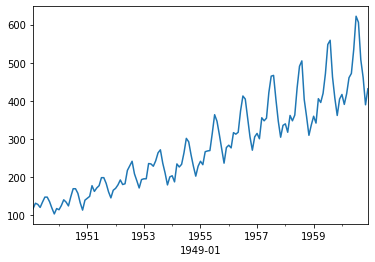

In [7]:
ts.plot()

In [8]:
num_lags = 12

In [9]:
ts_train, ts_test = ts[:100], ts[100 - num_lags:]

In [10]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [11]:
X_train, y_train = transform_into_matrix(ts_train, num_lags)

In [12]:
X_test, y_test = transform_into_matrix(ts_test, num_lags)

In [13]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=num_lags))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.fit(X_train, y_train, epochs=2000, verbose=0)

In [15]:
y_pred = model.predict(X_test)

In [16]:
plot_multiple_ts(ts_train, ts_test, pd.Series(y_pred.squeeze(), index=ts_test.index[num_lags:]))

### Использование полносвязной сети для предсказания следующих 12 точек

Задача - по предыдущем n точкам научиться предсказывать следующие m точек

In [206]:
ts = dataset['alcohol_sales.csv']

#### 1) Реализовать функцию разбиения одномерного ряда на входные данные для сетки

In [207]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Разбить на трейн и тест, отложив в качестве теста последние 12 точек

In [213]:
# ваш код здесь
num_lags = 24
num_output = 12
X, y = transform_ts_into_matrix(ts, num_lags, num_output)

In [214]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [215]:
# ваш код здесь
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_output))
model.compile(optimizer='adam', loss='mse')

#### 4) Обучить сеть.

In [216]:
#ваш код здесь
model.fit(X_train, y_train, epochs=400, verbose=0)

#### 5) Сделайте предикт на тесте и сравните результат с предыдущим подходом

In [217]:
# ваш код здесь
y_pred = model.predict(X_test)

In [218]:
plot_multiple_ts(pd.Series(y_pred.flatten(), index=ts.index[-12:]), ts)

### Использование полносвязной сети для предсказания многомерного ряда

In [27]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [28]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


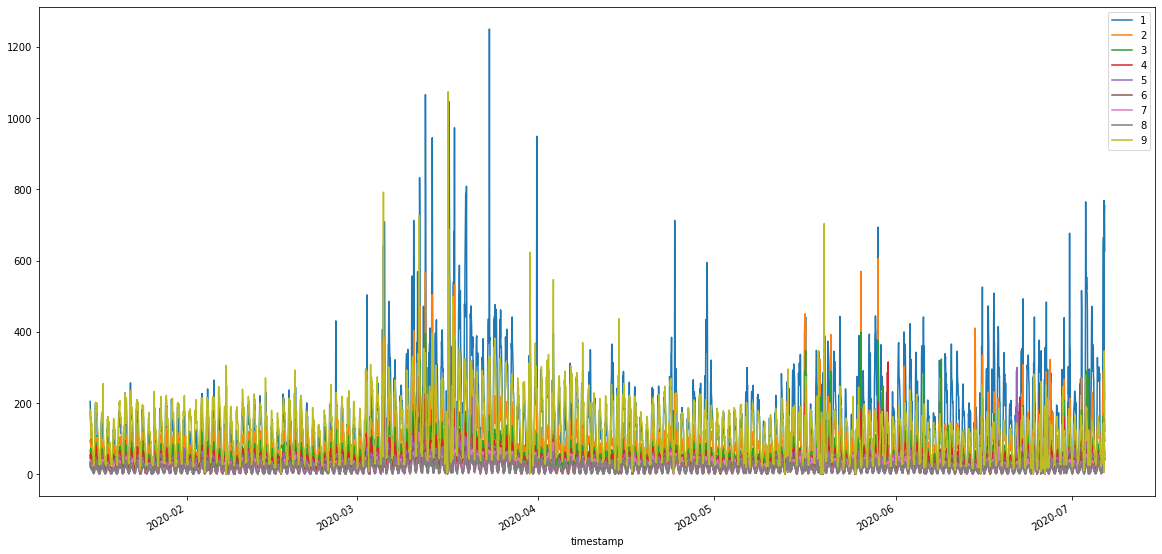

In [29]:
ts.plot(figsize=(20, 10))

In [115]:
ts.fillna(ts.median(), inplace=True)

#### 1) Реализовать функцию, которая разбивает исходный ряд на входные данные X и y для сетки

In [116]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x.T.flatten())
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [117]:
n_lags = 14

In [118]:
X, y = transform_multi_ts_into_matrix(ts, n_lags)

#### 2) Разбить на трейн и тест

In [119]:
# ваш код здесь

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [123]:
# ваш код здесь
n_dims = 9

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_dims*n_lags))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_dims))
model.compile(optimizer='adam', loss='mse')

####  4) Обучить модель 

In [124]:
# ваш код здесь
model.fit(X, y, epochs=200)

Epoch 1/200
130/130 [==============================] - 0s 832us/step - loss: 2740.8152
Epoch 2/200
130/130 [==============================] - 0s 803us/step - loss: 1230.8600
Epoch 3/200
130/130 [==============================] - 0s 785us/step - loss: 1122.8115
Epoch 4/200
130/130 [==============================] - 0s 738us/step - loss: 1026.8745
Epoch 5/200
130/130 [==============================] - 0s 771us/step - loss: 1006.0128
Epoch 6/200
130/130 [==============================] - 0s 902us/step - loss: 952.9507
Epoch 7/200
130/130 [==============================] - 0s 943us/step - loss: 931.3090
Epoch 8/200
130/130 [==============================] - 0s 845us/step - loss: 899.9006
Epoch 9/200
130/130 [==============================] - 0s 736us/step - loss: 887.6261
Epoch 10/200
130/130 [==============================] - 0s 737us/step - loss: 879.0226
Epoch 11/200
130/130 [==============================] - 0s 767us/step - loss: 849.3178
Epoch 12/200
130/130 [=========================

Epoch 96/200
130/130 [==============================] - 0s 733us/step - loss: 382.0245
Epoch 97/200
130/130 [==============================] - 0s 772us/step - loss: 391.2861
Epoch 98/200
130/130 [==============================] - 0s 1ms/step - loss: 376.3895
Epoch 99/200
130/130 [==============================] - 0s 977us/step - loss: 377.5825
Epoch 100/200
130/130 [==============================] - 0s 1ms/step - loss: 371.3082
Epoch 101/200
130/130 [==============================] - 0s 1ms/step - loss: 377.4740
Epoch 102/200
130/130 [==============================] - 0s 1ms/step - loss: 380.7399
Epoch 103/200
130/130 [==============================] - 0s 835us/step - loss: 365.7177
Epoch 104/200
130/130 [==============================] - 0s 805us/step - loss: 378.9371
Epoch 105/200
130/130 [==============================] - 0s 902us/step - loss: 383.8373
Epoch 106/200
130/130 [==============================] - 0s 995us/step - loss: 378.3039
Epoch 107/200
130/130 [=====================

In [125]:
model.predict(X)

array([[ 20.731913 ,  14.9787445,   9.828609 , ...,   5.6185465,
          5.3048797,  30.287632 ],
       [ 21.470053 ,  15.968155 ,  10.046621 , ...,   5.2624297,
          4.896508 ,  27.334167 ],
       [ 20.401724 ,  15.615377 ,   9.835447 , ...,   5.5889187,
          5.193783 ,  29.59174  ],
       ...,
       [694.3948   , 324.55994  , 196.66881  , ...,  72.23378  ,
         60.753975 , 326.2842   ],
       [777.3287   , 276.05322  , 186.45518  , ...,  57.081768 ,
         47.090115 , 247.40427  ],
       [581.7855   , 219.25693  , 166.17236  , ...,  51.010876 ,
         40.74291  , 189.94926  ]], dtype=float32)

In [128]:
ts.iloc[-2]

1    756.0
2    253.0
3    161.0
4    106.0
5     72.0
6     59.0
7     59.0
8     39.0
9    248.0
Name: 2020-07-06 15:00:00, dtype: float64